In [ ]:
import os
import sys
import numpy as np
from pathlib import Path
from typing import Generator, Optional, Tuple
from utils import build_sequences, load_txt_file

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent.parent))

# Import custom modules
from src.models.data_loader import DataLoader, Split
from src.models import TrainingArguments, LabeledData
from src.core.utils import data_analysis, context_manager
from src import Tensor, loss_functions, optimizers, metrics
from src.architectures.transformer import Tokenizer, DecoderTransformer
from src.architectures.transformer.config import TransformerConfig, TransformerBlockConfig, MLPConfig, AttentionConfig

### Constants and hyperparameters

In [20]:
# Constants
dataset_path = os.path.join(os.getcwd(), 'dataset', 'divina_commedia.txt')
tokenizer_path = os.path.join(os.getcwd(), 'checkpoints', 'tokenizer_divina_commedia.json')
model_path = os.path.join(os.getcwd(), 'checkpoints', 'language_model_divina_commedia')

In [ ]:
# Hyperparameters
dropout = 0.1 # The dropout rate
n_epochs = 30 # The number of epochs to train the model for
max_steps_per_epoch = 100 # Number of random training steps per epoch
max_eval_steps_per_epoch = 50 # Number of validation/test steps for faster evaluation
max_test_samples = 256 # Number of test samples for faster evaluation
train_test_split_pct = 0.1 # 90% of the data will be used for training, 10% for testing
train_valid_split_pct = 0.1 # 90% of the training data will be used for training, 10% for validation
batch_size = 8 # The number of samples to use for each batch
grad_accumulation_steps = 4 # The number of steps to accumulate gradients before updating the model
max_sequence_length = 256 # The size of the sequence length (the context window)
learning_rate = 1e-3 # The learning rate for the optimizer
weight_decay = 0.01 # The weight decay for the optimizer
seed = 42 # Random seed for reproducibility
n_embed = 384 # The size of the token embeddings (the dimensionality of the embeddings)
n_attention_heads = 6 # The number of attention heads in the multi-head attention mechanism
n_decoder_blocks = 6 # The number of transformer decoder blocks in the model

### Data loading

In [23]:
# Instantiate the tokenizer
tokenizer = Tokenizer()

# Load the state of the tokenizer
tokenizer.load(tokenizer_path)

# Extract the vocabulary size
vocab_size = tokenizer.get_vocab_size()

In [24]:
# Load the text file
text = load_txt_file(dataset_path)

# Encode the text using the tokenizer
encoded_text = tokenizer.encode(text)

# Convert the data to a tensor
data = np.array(encoded_text)

### Data preprocessing

In [25]:
# Split the token stream first to avoid leakage across train/valid/test
n_tokens = len(data)
test_tokens = max(1, int(n_tokens * train_test_split_pct))
train_valid_tokens = n_tokens - test_tokens
valid_tokens = max(1, int(train_valid_tokens * train_valid_split_pct))
train_tokens = train_valid_tokens - valid_tokens

# Extract the token splits
tokens_train = data[:train_tokens]
tokens_valid = data[train_tokens:train_tokens + valid_tokens]
tokens_test = data[train_tokens + valid_tokens:]

# Build the full sequence datasets for each split
X_train_data, y_train_data = build_sequences(tokens_train, max_sequence_length)
X_valid_data, y_valid_data = build_sequences(tokens_valid, max_sequence_length)
X_test_data, y_test_data = build_sequences(tokens_test, max_sequence_length)

# Convert the data to Tensors
X_train = Tensor(X_train_data.astype(np.int32))
y_train = Tensor(y_train_data.astype(np.int32))
X_valid = Tensor(X_valid_data.astype(np.int32))
y_valid = Tensor(y_valid_data.astype(np.int32))
X_test = Tensor(X_test_data.astype(np.int32))
y_test = Tensor(y_test_data.astype(np.int32))

In [26]:
# Print the dataset information
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (143112, 256) (143112, 256)
Validation set: (15673, 256) (15673, 256)
Testing set: (17443, 256) (17443, 256)


### Building the model

In [27]:
# Create the language model
language_model = DecoderTransformer(
    name = "Language Model",
    config = TransformerConfig(
        input_dim = vocab_size,
        embed_dim = n_embed,
        max_sequence_length = max_sequence_length,
        return_sequence = True,
        input_type = "discrete",
        positional_encoding_type = 'learned',
        num_blocks = n_decoder_blocks,
        block_config = TransformerBlockConfig(
            attention_config = AttentionConfig(
                num_heads = n_attention_heads,
                dropout = dropout,
                causal = True
            ),
            ffn_config = MLPConfig(
                dropout = dropout
            )
        )
    )
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy(from_logits=True)

### Initializing the model

In [28]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Call the model with a batch of data to initialize it
    language_model(X_train[:batch_size])

In [29]:
# Display the model summary in tree format.
# This is useful since the whole model is composed of submodules,
# therefore, the model summary will be displayed recursively
language_model.summary(recursive=True)

Language Model (DecoderTransformer) [output_shape=(8, 256, 1024), params=15073024]
└── language_model.modules (ModuleList) [output_shape=(8, 256, 1024), params=15073024]
    └── module_list.0 (Decoder) [output_shape=(8, 256, 1024), params=15073024]
        ├── decoder.input_proj (Embedding) [output_shape=(8, 256, 384), params=393216]
        ├── decoder.positional_encoding (Embedding) [output_shape=(256, 384), params=98304]
        ├── decoder.decoder_blocks (ModuleList) [output_shape=?, params=14186496]
        │   ├── module_list.0 (Block) [output_shape=(8, 256, 384), params=1773312]
        │   │   ├── block.layer_norm_1 (LayerNormalization) [output_shape=(8, 256, 384), params=768]
        │   │   ├── block.self_attention_heads (SelfMultiHeadAttention) [output_shape=(8, 256, 384), params=590208]
        │   │   │   ├── self_multi_head_attention.heads (ModuleList) [output_shape=?, params=442368]
        │   │   │   │   ├── module_list.0 (SelfSingleHeadAttention) [output_shape=(8, 256

### Training the model

In [30]:
# Define the data loader for language model training
class LanguageModelDataLoader(DataLoader):
    """
    DataLoader with random train sampling and sequential validation batches.
    """

    def __init__(
        self,
        train_data: LabeledData,
        valid_data: Optional[LabeledData] = None,
        max_train_steps_per_epoch: int = 100,
        max_eval_steps_per_epoch: int = 25,
        seed: int = 42
    ) -> None:
        """
        Initialize the data loader.

        Args:
        - train_data (LabeledData): The training data.
        - valid_data (Optional[LabeledData]): The validation data. If None, the validation split will be empty.
        - max_train_steps_per_epoch (int): The maximum number of training steps to take per epoch. 
            This is used to limit the number of random batches sampled during training.
        - max_eval_steps_per_epoch (int): The maximum number of evaluation steps to take per epoch for validation and testing. 
            This is used to limit the number of batches sampled during evaluation for faster evaluation.
        - seed (int): The random seed for reproducibility when sampling batches.
        """

        # Call the parent constructor to initialize the data splits
        super().__init__(train_data=train_data, valid_data=valid_data)

        # Store the maximum number of steps per epoch for training and evaluation
        self.max_train_steps_per_epoch = max_train_steps_per_epoch
        self.max_eval_steps_per_epoch = max_eval_steps_per_epoch

        # Initialize the random number generator for sampling batches
        self._rng = np.random.default_rng(seed)


    def get_batch(self, split: Split, batch_size: int) -> Generator[Tuple[Tuple[Tensor, ...], Tensor], None, None]:
        """
        Get a batch of data for the specified split.
        
        Args:
        - split (Split): The data split to get the batch from (train, valid, or test).
        - batch_size (int): The number of samples to include in the batch.
        
        Yields:
        - Tuple[Tuple[Tensor, ...], Tensor]: A tuple containing the input tensors and the target tensor for the batch.
        """

        # Get the data for the specified split
        data = self._get_data_split(split)

        # Determine the number of steps to take based on the split
        num_steps = self.num_batches(split=split)

        # Extract the inputs and targets from the data
        data_inputs = data.input_tuple
        data_targets = data.target

        # Get the number of samples in the dataset
        n_samples = data_inputs[0].shape[0]

        # Iterate for the specified number of steps and yield batches of data
        for _ in range(num_steps):
            # Sample random indices for the batch
            batch_indices = self._rng.integers(0, n_samples, size=batch_size)

            # Create the batch of input tensors and target tensor using the sampled indices
            x_batch = tuple(tensor[batch_indices] for tensor in data_inputs)
            y_batch = data_targets[batch_indices]

            # Yield the batch of input tensors and target tensor
            yield x_batch, y_batch


    def num_batches(self, split: Split, *args, **kwargs) -> int:
        """
        Get the number of batches to take for the specified split.
        
        Args:
        - split (Split): The data split to get the number of batches for (train, valid, or test).
        
        Returns:
        - int: The number of batches to take for the specified split.
        """

        # Determine the number of steps to take based on the split
        if split == Split.TRAIN:
            return self.max_train_steps_per_epoch
        if split == Split.VALID:
            return self.max_eval_steps_per_epoch

In [31]:
# Create the training arguments
train_arguments = TrainingArguments(
    data_loader = LanguageModelDataLoader(
        train_data = LabeledData(input={'x': X_train}, target=y_train),
        valid_data = LabeledData(input={'x': X_valid}, target=y_valid),
        max_train_steps_per_epoch = max_steps_per_epoch,
        max_eval_steps_per_epoch = max_eval_steps_per_epoch,
        seed = seed
    ),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = n_epochs,
    gradient_accumulation_steps = grad_accumulation_steps
)

# Train the model
history = language_model.fit(train_arguments)

Epoch 1/30 --> loss: 4.6037 | val_loss: 4.1297                                                                                                       
Epoch 2/30 --> loss: 3.9696 | val_loss: 3.8222                                                                                                       
Epoch 3/30 --> loss: 3.7533 | val_loss: 3.6324                                                                                                       
Epoch 4/30 --> loss: 3.5642 | val_loss: 3.4594                                                                                                       
Epoch 5/30 --> loss: 3.3811 | val_loss: 3.3144                                                                                                       
Epoch 6/30 --> loss: 3.2602 | val_loss: 3.2356                                                                                                       
Epoch 7/30 --> loss: 3.1726 | val_loss: 3.1758                                                      

In [32]:
# Save the model 
language_model.save(model_path)

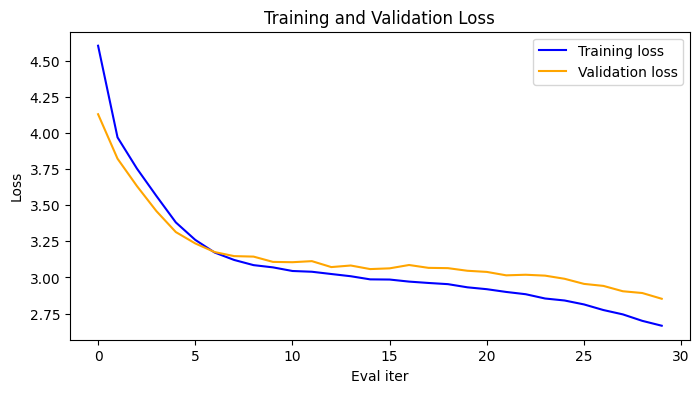

In [33]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = language_model.history["loss"], 
    valid_loss = language_model.history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Eval iter",
    ylabel = "Loss"
)

### Evaluation

In [34]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Compute the predictions
    predictions_out = language_model(X_test[:max_test_samples], batch_size=batch_size, verbose=True)

# Apply argmax to get token predictions
predictions = Tensor(np.argmax(predictions_out.output.to_numpy(), axis=-1).astype(np.int32), dtype=np.int32)

Processing batch 32/32 - 173.95 ms/step

In [35]:
# Compute next-token accuracy from the last position
accuracy = metrics.accuracy(y_test[:max_test_samples, -1], predictions[:, -1])

# Print the accuracy
print(f"Accuracy: {accuracy.data:.2f}")

Accuracy: 0.35


### Inference

In [36]:
# Generate some text context from the trained model
context = Tensor(np.zeros((1, 1), dtype=np.int32))

# Iterate over the tokens generated by the transformer
for token in language_model.autoregressive_generation(x=context, num_steps=200, stream=True, do_sample=True):
    # Decode the token
    decoded_token = tokenizer.decode([token.data.squeeze().tolist()])

    # Print the decoded token
    print(decoded_token, end='', flush=True)

,
tal che l'un non ch'era te inferno,
come quelle in fuor ssue divino,
ch'io non atti salvo,
e ch'io per l'affollo alscia bate sonno fanda
umane da;
di vidi tieni in se gran guinno,
chia,
quel ciel porti che mai ch'i' dove Accato eda indura prieader ava
delli schivoto sanza
ddea una nesso li naita as
che, tutto la vist